## Install Yfinance

In [ ]:
pip install yfinance

## Libraries

In [ ]:
## Data
import yfinance as yf

## Feature Engineering
import pandas as pd
import numpy as np

## HPO & Training
from scipy.stats import randint
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

## Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Data

In [ ]:
start = "1990-01-01"
end = "2024-01-01"

TICKER = yf.Ticker("SPY")
SPY = TICKER.history(start=start,end=end)
data = SPY[['Open','High','Low','Close']]

## Function

In [ ]:
def SMA(df,n):
  data[str(n) + "_SMA"] = (data.Close / data.Close.rolling(50).mean())

In [ ]:
def RSI(df, n=14):
    Price_Change = df['Close'].diff()

    # Calculate the average gain and average loss
    Gain = Price_Change.where(Price_Change > 0, 0)
    Loss = -Price_Change.where(Price_Change < 0, 0)
    Avg_Gain = Gain.rolling(window=n, min_periods=1).mean()
    Avg_Loss = Loss.rolling(window=n, min_periods=1).mean()

    # Calculate the relative strength (RS)
    RS = Avg_Gain / Avg_Loss

    # Calculate the RSI
    df[str(n) + '_RSI'] = 100 - (100 / (1 + RS))

In [ ]:
def is_close_price_higher(df):
    open_price = df['Open']
    close_price = df['Close']
    signal =  (1 if close_price > open_price else 0)
    df['signal'] = signal

## Feature Engineering

In [ ]:
data['Signal'] = data.apply(lambda row: 1 if row['Close'] > row['Open'] else 0, axis=1)

for i in range(5,100,5):
  SMA(df = data, n = i)

for i in range(4,30,2):
  RSI(df = data, n = i)

<ipython-input-43-5712215681bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'] = data.apply(lambda row: 1 if row['Close'] > row['Open'] else 0, axis=1)
<ipython-input-40-17e569242934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[str(n) + "_SMA"] = (data.Close / data.Close.rolling(50).mean())
<ipython-input-40-17e569242934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Model Prep

In [ ]:
data = data.dropna()

In [ ]:
X = data.iloc[:,5:]
y = data['Signal']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## HPO

In [ ]:
# Define hyperparameters to optimize
param_grid = {
    'n_estimators': randint(100,500),
    'learning_rate': random.choices(np.arange(0.1,1,0.05)),
    'max_depth': randint(1,10),
    'subsample': random.choices(np.arange(0.1,1,0.05)),
    'reg_alpha': [0.01,0.1,1,10],
    'objective': ['binary:logistic']
}

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()

# Perform hyperparameter optimization using GridSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier,
    param_distributions=param_grid,
    n_iter=20,  # specify the number of iterations
    cv=2,  # specify the number of cross-validation folds
    verbose=3
    )

random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END learning_rate=0.9500000000000003, max_depth=4, n_estimators=441, objective=binary:logistic, reg_alpha=1, subsample=0.7000000000000002;, score=0.566 total time=  24.9s
[CV 2/2] END learning_rate=0.9500000000000003, max_depth=4, n_estimators=441, objective=binary:logistic, reg_alpha=1, subsample=0.7000000000000002;, score=0.565 total time=   1.3s
[CV 1/2] END learning_rate=0.9500000000000003, max_depth=3, n_estimators=261, objective=binary:logistic, reg_alpha=1, subsample=0.7000000000000002;, score=0.569 total time=   0.6s
[CV 2/2] END learning_rate=0.9500000000000003, max_depth=3, n_estimators=261, objective=binary:logistic, reg_alpha=1, subsample=0.7000000000000002;, score=0.569 total time=   0.6s
[CV 1/2] END learning_rate=0.9500000000000003, max_depth=5, n_estimators=135, objective=binary:logistic, reg_alpha=0.1, subsample=0.7000000000000002;, score=0.562 total time=   0.6s
[CV 2/2] END learning_rate=0.95000000

In [ ]:
# Train the classifier with the best hyperparameters on the training data
best_xgb_classifier = XGBClassifier(**best_params)
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_xgb_classifier.predict(X_test)

# Evaluate the model
classification_report_str = classification_report(y_test, y_pred)

# Print the best hyperparameters and evaluation results
print('Classification Report:')
print(classification_report_str)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       761
           1       0.61      0.69      0.65       780

    accuracy                           0.62      1541
   macro avg       0.62      0.62      0.62      1541
weighted avg       0.62      0.62      0.62      1541



In [ ]:
# Make predictions on the test set
y_pred_prob = best_xgb_classifier.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1.01, 0.01)
precision_scores_class_0 = []
precision_scores_class_1 = []

for threshold in thresholds:
    y_pred = (y_pred_prob > threshold).astype(int)
    precision = precision_score(y_test, y_pred, average=None)
    precision_scores_class_0.append(precision[0])
    precision_scores_class_1.append(precision[1])

fig = go.Figure()

fig.add_trace(go.Scatter(x=thresholds, y=precision_scores_class_0, mode='lines', name='Precision Class 0'))
fig.add_trace(go.Scatter(x=thresholds, y=precision_scores_class_1, mode='lines', name='Precision Class 1'))

fig.update_layout(
    title='Precision Scores for Both Classes at Different Thresholds',
    xaxis=dict(title='Threshold'),
    yaxis=dict(title='Precision Score'),
    legend=dict(x=0, y=1, traceorder='normal')
)

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/p

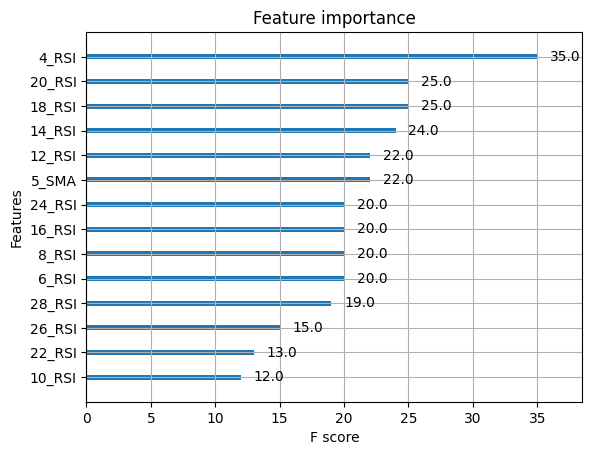

In [ ]:
plot_importance(best_xgb_classifier)
plt.show()

## Daily Run

In [ ]:
start = "2022-01-01"
end = "2023-11-12"

TICKER = yf.Ticker("SPY")
SPY = TICKER.history(start=start,end=end)
data = SPY[['Open','High','Low','Close']]

for i in range(5,100,5):
  SMA(df = data, n = i)

for i in range(4,30,2):
  RSI(df = data, n = i)

<ipython-input-40-17e569242934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[str(n) + "_SMA"] = (data.Close / data.Close.rolling(50).mean())
<ipython-input-40-17e569242934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[str(n) + "_SMA"] = (data.Close / data.Close.rolling(50).mean())
<ipython-input-40-17e569242934>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
buy_call = best_xgb_classifier.predict_proba(data.tail(1).iloc[:,4:])[0][1] >= 0.85

In [ ]:
buy_put = best_xgb_classifier.predict_proba(data.tail(1).iloc[:,4:])[0][1] <= 0.15

In [ ]:
print("Should I buy a call? :", buy_call)
print("Should I buy a put? :", buy_put)

Should I buy a call? : False
Should I buy a put? : False


In [ ]:
best_xgb_classifier.predict(data.tail(1).iloc[:,4:])

array([1])

In [ ]:
data.tail(1)

,Open,High,Low,Close,5_SMA,10_SMA,15_SMA,20_SMA,25_SMA,30_SMA,...,10_RSI,12_RSI,14_RSI,16_RSI,18_RSI,20_RSI,22_RSI,24_RSI,26_RSI,28_RSI
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-10 00:00:00-05:00,435.980011,440.929993,433.829987,440.609985,1.018922,1.018922,1.018922,1.018922,1.018922,1.018922,...,90.721078,76.432829,69.056161,62.049614,53.353788,56.240566,52.756699,55.083071,58.986932,60.241209
